In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelBinarizer
from torchvision.io import read_image
import os
import glob
import random
import pandas as pd
import seaborn as sn
from cloudnet import *
from casv3 import *
from early_stopping import *
import albumentations as A
from albumentations.pytorch import ToTensorV2
import copy
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda', index=1)

In [5]:
import wandb
!WANDB_NOTEBOOK_NAME='ResNet-50CAS.ipynb'
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mario-andonaire (use `wandb login --relogin` to force relogin)


True

In [6]:
config={
    "learning_rate": 0.0003,
    "architecture": "CloudNet",
    "dataset": "CAS_10c_f",
    "epochs": 40,
    "batch_size": 4,
    "reduce_factor": 10,
    "print_epochs": 5,
    "print_times_per_epoch":20,
    "reduce_epochs": 2000,
    "optimizer": "Adam"
}

In [7]:
wandb.init(
  # Set the project where this run will be logged
  project="cloud-classification", 
  # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
  name=f"experiment_{config['architecture']}_{config['dataset']}", 
  # Track hyperparameters and run metadata
  config=config)

In [8]:
""" Load pretrained model """
model = CloudNet()
in_ftrs = model.fc3.in_features
model.fc3 = nn.Linear(in_ftrs, CAS.get_n_classes())
#model.load_state_dict(torch.load('./resnet50HBMCD.pth'))

In [9]:
model = model.to(device)
model = model.apply(weights_init)
wandb.watch(model)

[]

In [5]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=250),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=227, width=227),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
validation_transform = A.Compose(
    [
        A.Resize (height=227, width=227),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [6]:
train_data = CAS(transform=train_transform, data_path='/data/mandonaire/Cloudappreciationsociety/filtered_images_data_aug/train.csv')
validation_data = CAS(transform=validation_transform, data_path='/data/mandonaire/Cloudappreciationsociety/filtered_images_data_aug/validation.csv')

In [7]:
len(train_data)

8748

In [22]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

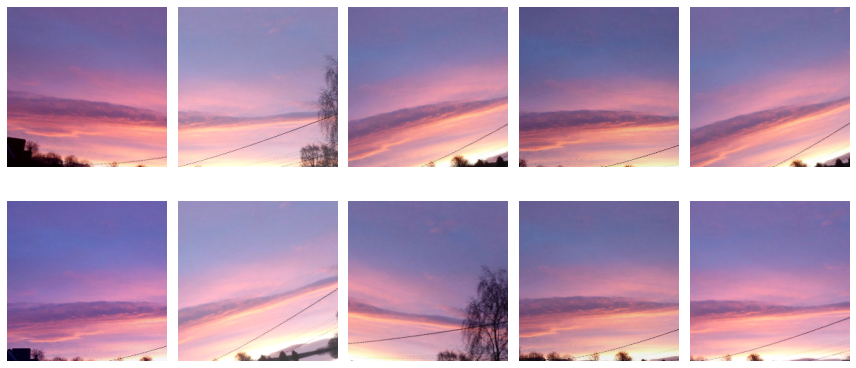

In [23]:
random.seed(42)
visualize_augmentations(train_data, samples=10, idx=150)

In [24]:
train_loader = DataLoader(train_data, batch_size=config["batch_size"], shuffle=True, pin_memory=True)
validation_loader = DataLoader(validation_data, batch_size=12, shuffle=False, pin_memory=True)

In [25]:
n_total_steps = len(train_loader)
n_total_steps

2501

In [26]:
learning_rate = config["learning_rate"]
num_epochs = config["epochs"]
reduce_factor = config["reduce_factor"]
print_epochs = config["print_epochs"] # 5
reduce_epochs = config["reduce_epochs"] # 20
batch_size = config["batch_size"]
print_times_per_epoch = config["print_times_per_epoch"]
running_loss = 0.0
running_correct = 0
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  5%|▍         | 125/2501 [00:07<02:12, 17.87it/s]

Epoch [1/40], Step [124/2501], Loss: 3.5014


 10%|▉         | 249/2501 [00:14<02:07, 17.68it/s]

Epoch [1/40], Step [248/2501], Loss: 2.2396


 15%|█▍        | 374/2501 [00:21<02:01, 17.52it/s]

Epoch [1/40], Step [372/2501], Loss: 2.2030


 20%|█▉        | 497/2501 [00:28<01:55, 17.36it/s]

Epoch [1/40], Step [496/2501], Loss: 2.0394


 25%|██▍       | 622/2501 [00:35<01:52, 16.66it/s]

Epoch [1/40], Step [620/2501], Loss: 1.3818


 30%|██▉       | 745/2501 [00:42<01:39, 17.63it/s]

Epoch [1/40], Step [744/2501], Loss: 1.3959


 35%|███▍      | 870/2501 [00:50<01:40, 16.26it/s]

Epoch [1/40], Step [868/2501], Loss: 1.7905


 40%|███▉      | 993/2501 [00:57<01:29, 16.84it/s]

Epoch [1/40], Step [992/2501], Loss: 1.9131


 45%|████▍     | 1117/2501 [01:04<01:24, 16.43it/s]

Epoch [1/40], Step [1116/2501], Loss: 1.5286


 50%|████▉     | 1242/2501 [01:11<01:13, 17.09it/s]

Epoch [1/40], Step [1240/2501], Loss: 2.2191


 55%|█████▍    | 1366/2501 [01:19<01:04, 17.57it/s]

Epoch [1/40], Step [1364/2501], Loss: 2.2989


 60%|█████▉    | 1490/2501 [01:26<01:03, 15.90it/s]

Epoch [1/40], Step [1488/2501], Loss: 1.9750


 65%|██████▍   | 1614/2501 [01:33<00:49, 17.84it/s]

Epoch [1/40], Step [1612/2501], Loss: 2.3893


 69%|██████▉   | 1737/2501 [01:40<00:43, 17.67it/s]

Epoch [1/40], Step [1736/2501], Loss: 2.1533


 74%|███████▍  | 1862/2501 [01:48<00:38, 16.63it/s]

Epoch [1/40], Step [1860/2501], Loss: 2.0673


 79%|███████▉  | 1985/2501 [01:55<00:30, 17.05it/s]

Epoch [1/40], Step [1984/2501], Loss: 1.6331


 84%|████████▍ | 2110/2501 [02:02<00:21, 18.20it/s]

Epoch [1/40], Step [2108/2501], Loss: 1.9246


 89%|████████▉ | 2233/2501 [02:09<00:15, 17.34it/s]

Epoch [1/40], Step [2232/2501], Loss: 1.8765


 94%|█████████▍| 2358/2501 [02:17<00:08, 16.34it/s]

Epoch [1/40], Step [2356/2501], Loss: 1.1452


 99%|█████████▉| 2480/2501 [02:24<00:01, 16.22it/s]

Epoch [1/40], Step [2480/2501], Loss: 2.0360


100%|██████████| 2501/2501 [02:25<00:00, 17.20it/s]


Epoch [2/40], Step [124/2501], Loss: 2.2113
Epoch [2/40], Step [248/2501], Loss: 1.8766
Epoch [2/40], Step [372/2501], Loss: 2.6336
Epoch [2/40], Step [496/2501], Loss: 2.5190
Epoch [2/40], Step [620/2501], Loss: 1.2622
Epoch [2/40], Step [744/2501], Loss: 3.2086
Epoch [2/40], Step [868/2501], Loss: 2.2447
Epoch [2/40], Step [992/2501], Loss: 2.1369
Epoch [2/40], Step [1116/2501], Loss: 2.0651
Epoch [2/40], Step [1240/2501], Loss: 1.6666
Epoch [2/40], Step [1364/2501], Loss: 1.8743
Epoch [2/40], Step [1488/2501], Loss: 2.5664
Epoch [2/40], Step [1612/2501], Loss: 2.5221
Epoch [2/40], Step [1736/2501], Loss: 1.6055
Epoch [2/40], Step [1860/2501], Loss: 1.6997
Epoch [2/40], Step [1984/2501], Loss: 1.8020
Epoch [2/40], Step [2108/2501], Loss: 1.5227
Epoch [2/40], Step [2232/2501], Loss: 2.5328
Epoch [2/40], Step [2356/2501], Loss: 1.6870
Epoch [2/40], Step [2480/2501], Loss: 1.4866
Epoch [3/40], Step [124/2501], Loss: 1.6058
Epoch [3/40], Step [248/2501], Loss: 2.2297
Epoch [3/40], Step [

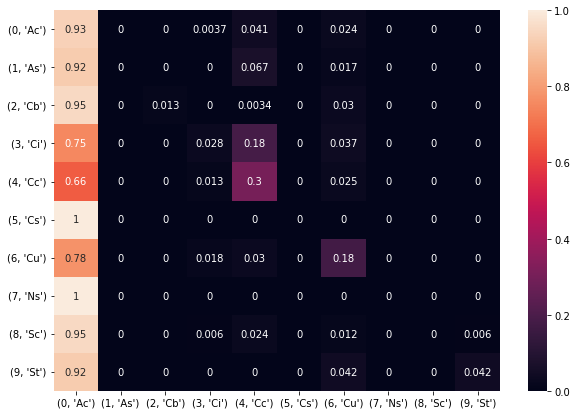

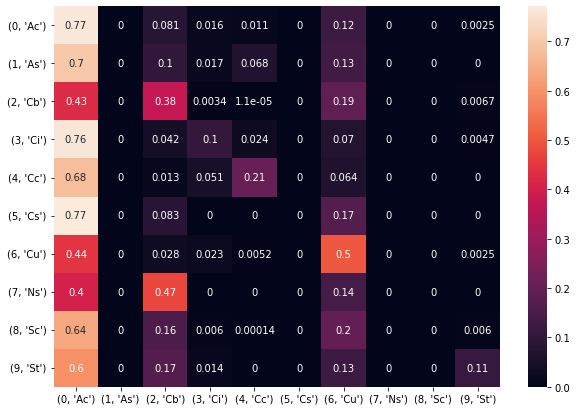

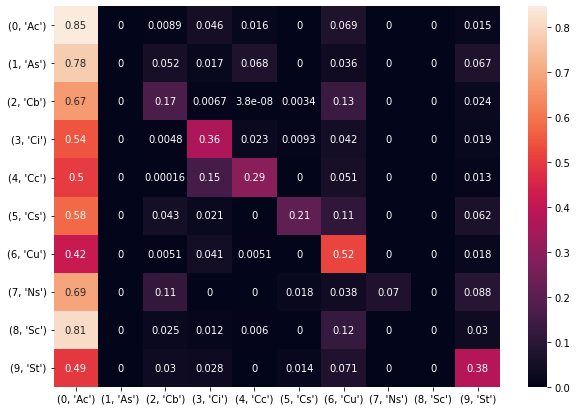

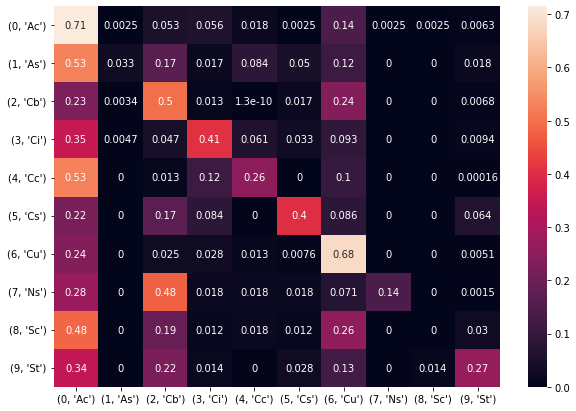

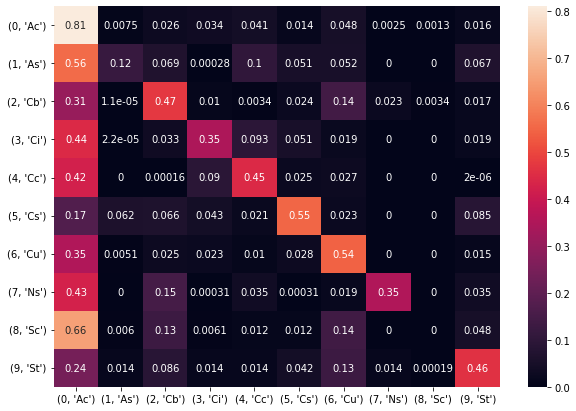

wandb: Network error (ConnectionError), entering retry loop.


In [27]:
classes = train_data.classes
matrix = np.zeros((len(classes), len(classes)))
batch_size_validation = 12
early_stopping = EarlyStopping(tolerance=5, min_delta=0.4)
model.train()
stream = tqdm(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(stream, start=1):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        if (i+1) % (n_total_steps//print_times_per_epoch - 1) == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            running_accuracy = running_correct / 100 / predicted.size(0)
            running_correct = 0
            running_loss = 0.0
            wandb.log({"loss": loss, "running_accuracy" : running_accuracy})
          
    # Print validation loss and cofusion matrix
    if (epoch+1) % print_epochs == 0  or (epoch+1) == num_epochs:
        # validation the model so far
        model.eval()  # handle drop-out/batch norm layers
        loss_validation = 0
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(len(classes))]
        n_class_samples = [0 for i in range(len(classes))]
        with torch.no_grad():
            for i, (images, labels) in enumerate(validation_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)  # only forward pass - NO gradients!!
                loss_validation += criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                n_samples += labels.size(0)
                n_correct += (predicted == labels).sum().item()
                for i in range(batch_size_validation):
                    try:
                        label = labels[i]
                        pred = predicted[i]
                        matrix[label][pred] += 1
                        if (label == pred):
                            n_class_correct[label] += 1
                        n_class_samples[label] += 1
                    except:
                        continue
                        
        acc = 100.0 * n_correct / n_samples
        wandb.log({"accuracy": acc})
        # total loss - divide by number of batches
        loss_validation = loss_validation / len(validation_loader)
        print (f'Epoch [{epoch+1}/{num_epochs}], Loss validation: {loss_validation:.4f}')
        wandb.log({"loss_validation": loss_validation})
        wandb.log({"delta_loss": loss_validation - loss})
        
        for i in range(len(classes)):
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            matrix[i] = matrix[i] / n_class_samples[i]
            print(f'Accuracy of {classes[i]}: {acc} %')
        
        df_cm = pd.DataFrame(matrix, index = train_data.classes,
                          columns = train_data.classes)
        plt.figure(figsize = (10,7))
        sn.heatmap(df_cm, annot=True)
        wandb.log({"confusion_matrix": wandb.Image(plt)})
        model.train()

    # Learning rate reduction
    if (epoch+1) % reduce_epochs == 0:
        if reduce_factor:
            for g in optimizer.param_groups:
                g['lr'] = g['lr']/reduce_factor
                
    # Early stopping
    try:
        early_stopping(loss, loss_validation)
        if early_stopping.early_stop:
            print("Stopped at epoch:", epoch)
            break
    except:
        pass


    
print('Finished Training')
PATH = os.path.join(wandb.run.dir, "model.pth")
torch.save(model.state_dict(), PATH)

average accuracy of the model:  0.682648401826484
F1 Macro:  0.5695873538655827
F1 Micro:  0.682648401826484
Accuracy of (0, 'Ac'): 76.125 %
Accuracy of (1, 'As'): 28.333333333333332 %
Accuracy of (2, 'Cb'): 79.86577181208054 %
Accuracy of (3, 'Ci'): 64.65116279069767 %
Accuracy of (4, 'Cc'): 40.50632911392405 %
Accuracy of (5, 'Cs'): 58.333333333333336 %
Accuracy of (6, 'Cu'): 77.41116751269035 %
Accuracy of (7, 'Ns'): 56.14035087719298 %
Accuracy of (8, 'Sc'): 28.143712574850298 %
Accuracy of (9, 'St'): 66.66666666666667 %


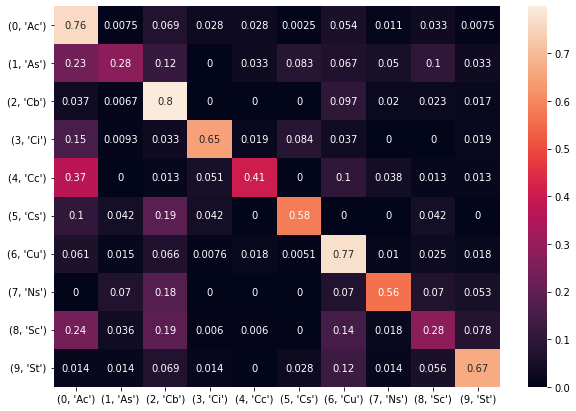

In [19]:
 # test the model so far
model.eval()  # handle drop-out/batch norm layers
loss_validation = 0
n_correct = 0
n_samples = 0
n_class_correct = [0 for i in range(len(classes))]
n_class_samples = [0 for i in range(len(classes))]
matrix = np.zeros((len(classes), len(classes)))
labels_f1 = []
predicted_f1 = []
with torch.no_grad():
    for i, (images, labels) in enumerate(validation_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)  # only forward pass - NO gradients!!
        loss_validation += criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        labels_f1.append(labels)
        predicted_f1.append(predicted)
        for i in range(batch_size_validation):
            try:
                label = labels[i]
                pred = predicted[i]
                matrix[label][pred] += 1
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1
            except:
                continue
                
predicted_f1 = torch.cat(predicted_f1).tolist()
labels_f1 = torch.cat(labels_f1).tolist()
avg_accuracy = accuracy_score(labels_f1, predicted_f1)
f1_macro = f1_score(labels_f1, predicted_f1, average="macro")
f1_micro = f1_score(labels_f1, predicted_f1, average="micro")
print("average accuracy of the model: ", avg_accuracy)
print("F1 Macro: ", f1_macro)
print("F1 Micro: ", f1_micro)
acc = 100.0 * n_correct / n_samples
wandb.log({"accuracy": acc})
wandb.log({"avg_accuracy": acc})
wandb.log({"f1_macro": f1_macro})
wandb.log({"f1_micro": f1_micro})
# total loss - divide by number of batches
loss_validation = loss_validation / len(validation_loader)
wandb.log({"loss_validation": loss_validation})
wandb.log({"delta_loss": loss_validation - loss})

for i in range(len(classes)):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    matrix[i] = matrix[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')

df_cm = pd.DataFrame(matrix, index = train_data.classes,
                  columns = train_data.classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
wandb.log({"confusion_matrix": wandb.Image(plt)})

In [20]:
wandb.finish()

accuracy,▁▂██
avg_accuracy,▁
delta_loss,▅█▁▆
f1_macro,▁
f1_micro,▁
loss,▆▅▇▇▃▆▄▅▇▄▂▃▅▅▄▂▅▂▃▅▃▂▁▄▃▂▃▂▂▇▅▃▅▄▂█▂▂▃▃
loss_test,▅█▂▁
running_accuracy,▁▂▃▃▃▄▄▄▄▅▄▆▅▆▆▅▆▆▇▆▆▇▆▇▇▆██▇██▇███▆███▇
accuracy,68.26484
avg_accuracy,68.26484
delta_loss,0.39981
